In [2]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jangedoo/utkface-new

 96% 317M/331M [00:02<00:00, 162MB/s]
100% 331M/331M [00:02<00:00, 129MB/s]


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import os
! unzip utkface-new

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [5]:
import os
import shutil
import random
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import keras
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
import tensorflow as tf
from numpy import savez_compressed
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.layers import Input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, ReLU, BatchNormalization, Conv2D,  MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
utkface_path = '/content/UTKFace/'  
trial_path = '/content/Trial/'

if not os.path.exists(trial_path):
    os.mkdir(trial_path)

genders = [0, 1]
max_num_files = 25

for age in range(1, 80):
    for gender in genders:
        age_gender_files = [f for f in os.listdir(utkface_path) if f.startswith(f"{age}_{gender}_")]
        num_files = len(age_gender_files)
        if num_files < max_num_files:
            num_to_augment = max_num_files - num_files
            for i in range(num_to_augment):
                # Randomly select an existing image
                source_file = random.choice(age_gender_files)
                source_path = os.path.join(utkface_path, source_file)
                dest_file = f"{age}_{gender}_{num_files+i}.jpg"
                dest_path = os.path.join(trial_path, dest_file)
                
                # Apply image augmentation
                img = Image.open(source_path)
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(0.5)
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(0.5)
                img.save(dest_path)
                
        elif num_files >= max_num_files:
            num_files = max_num_files
            
        for i in range(num_files):
            source_file = age_gender_files[i]
            source_path = os.path.join(utkface_path, source_file)
            dest_path = os.path.join(trial_path, source_file)
            shutil.copy(source_path, dest_path)


In [7]:
len(os.listdir(trial_path))

3950

In [8]:
# Load the Haar cascade file for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
#face_cascade

files = os.listdir(trial_path)
size = len(files)
size_genders = len(genders)
print("Total samples:",size)

Total samples: 3950


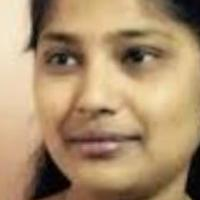

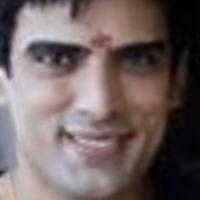

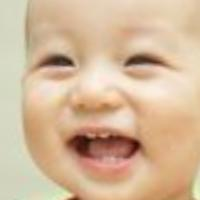

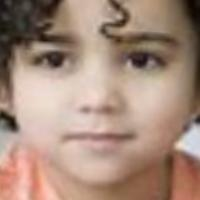

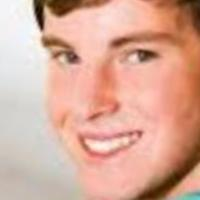

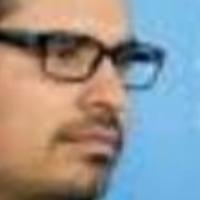

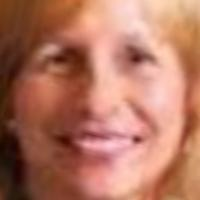

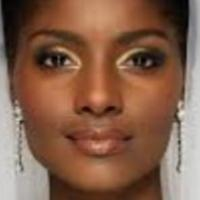

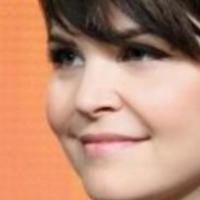

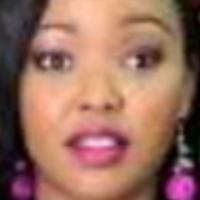

In [9]:
for i in range(10):
    image_path = os.path.join(trial_path, files[i])
    image = cv2.imread(image_path)
    cv2_imshow(image)

In [10]:
img_age_list = []
img_gender_list = []
ages = []
genders = []
filenames = []

for filename in files:
    image_age = cv2.imread(trial_path + filename,1) #,0 for convert the image into gray scale 1 for colour channel
    image_age = cv2.resize(image_age,dsize=(224,224))
    image_gender = cv2.imread(trial_path + filename,1) #,0 for convert the image into gray scale 1 for colour channel
    image_gender = cv2.resize(image_gender,dsize=(224,224))
    img_age_list.append(image_age)
    img_gender_list.append(image_gender)
    ages.append(filename.split('_')[0])
    genders.append(int(filename.split('_')[1]))
    filenames.append(filename)

(224, 224, 3)
(224, 224, 3)


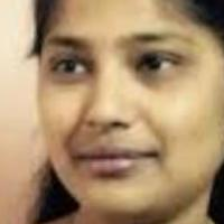

In [11]:
#kitty = np.stack([kitty]*3, axis=-1)
print(image_age.shape)
print(image_gender.shape)
cv2_imshow(img_age_list[0])

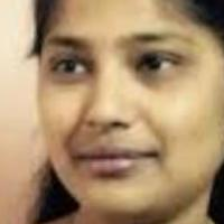

In [12]:
cv2_imshow(img_gender_list[0])

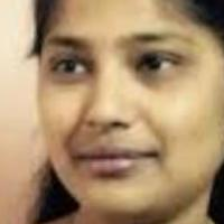

Filename: 27_1_3_20170119194359132.jpg.chip.jpg
Actual age: 27
Actual Gender: 1


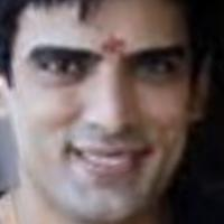

Filename: 25_0_3_20170117151048707.jpg.chip.jpg
Actual age: 25
Actual Gender: 0


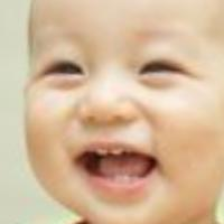

Filename: 1_0_2_20161219161919870.jpg.chip.jpg
Actual age: 1
Actual Gender: 0


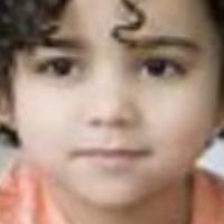

Filename: 2_1_4_20170103205810354.jpg.chip.jpg
Actual age: 2
Actual Gender: 1


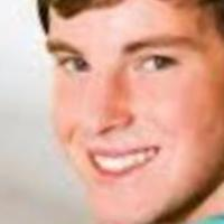

Filename: 20_0_0_20170105183430767.jpg.chip.jpg
Actual age: 20
Actual Gender: 0


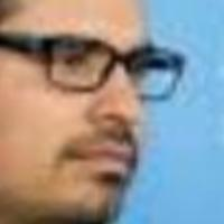

Filename: 26_0_4_20170117200225399.jpg.chip.jpg
Actual age: 26
Actual Gender: 0


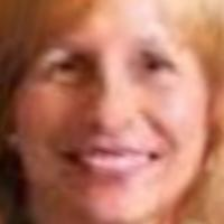

Filename: 40_1_0_20170117091304525.jpg.chip.jpg
Actual age: 40
Actual Gender: 1


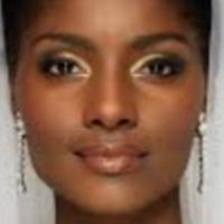

Filename: 20_1_1_20170113005500606.jpg.chip.jpg
Actual age: 20
Actual Gender: 1


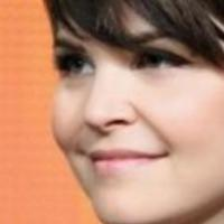

Filename: 26_1_0_20170117175317465.jpg.chip.jpg
Actual age: 26
Actual Gender: 1


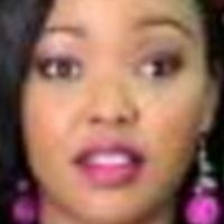

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Actual age: 26
Actual Gender: 1


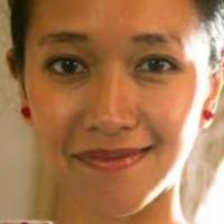

Filename: 29_1_2_20170116220903106.jpg.chip.jpg
Actual age: 29
Actual Gender: 1


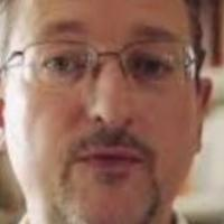

Filename: 43_0_0_20170117155014385.jpg.chip.jpg
Actual age: 43
Actual Gender: 0


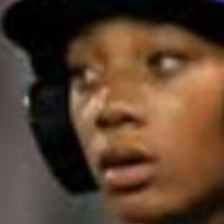

Filename: 26_1_1_20170116180048447.jpg.chip.jpg
Actual age: 26
Actual Gender: 1


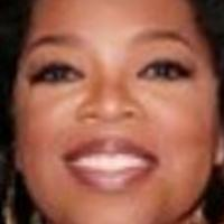

Filename: 40_1_1_20170113001043722.jpg.chip.jpg
Actual age: 40
Actual Gender: 1


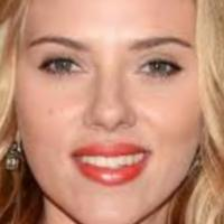

Filename: 28_1_0_20170117174702574.jpg.chip.jpg
Actual age: 28
Actual Gender: 1


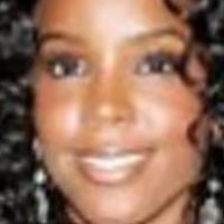

Filename: 40_1_1_20170113001848827.jpg.chip.jpg
Actual age: 40
Actual Gender: 1


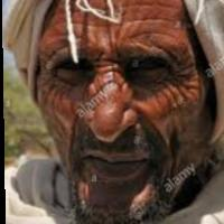

Filename: 63_0_4_20170117175627092.jpg.chip.jpg
Actual age: 63
Actual Gender: 0


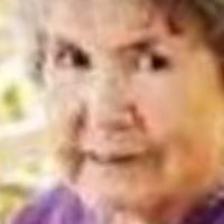

Filename: 63_0_0_20170109011137735.jpg.chip.jpg
Actual age: 63
Actual Gender: 0


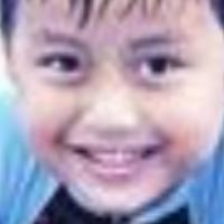

Filename: 5_0_2_20161219192503459.jpg.chip.jpg
Actual age: 5
Actual Gender: 0


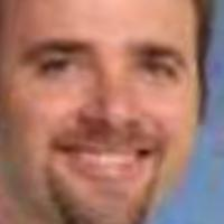

Filename: 34_0_0_20170104170059137.jpg.chip.jpg
Actual age: 34
Actual Gender: 0
Total samples for age: 3950
Total samples for gender: 3950
Total samples for gender: 3950
Total samples for gender: 3950


In [13]:
total_image_age_list = len(img_age_list)
total_image_gender_list = len(img_gender_list)
total_genders = len(genders)
total_ages = len(ages)
idx = 2
for i in range(20):
  cv2_imshow(img_gender_list[i])
  name_of_files = filenames[i]
  print("Filename:", name_of_files)
  print("Actual age:", ages[i])
  print("Actual Gender:",(genders[i]))
print("Total samples for age:",total_image_age_list)
print("Total samples for gender:",total_image_gender_list)
print("Total samples for gender:",total_genders)
print("Total samples for gender:",total_ages)

In [14]:
size_genders

2

In [15]:
for_np0 = img_gender_list[0]

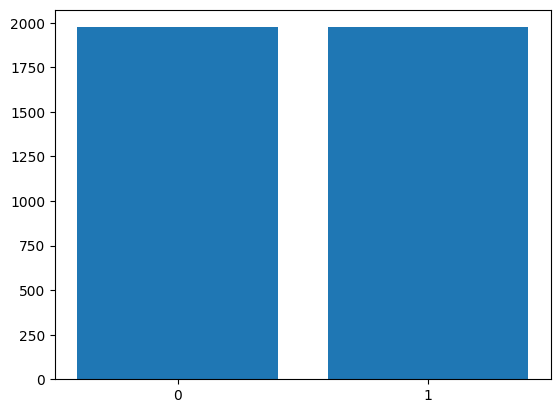

Max value: 1


In [16]:
x_genders = list(set(genders))
y_genders = [genders.count(i) for i in x_genders]

gender_labels = ['0', '1']
plt.bar(gender_labels, y_genders)

plt.show()
print("Max value:",max(genders))


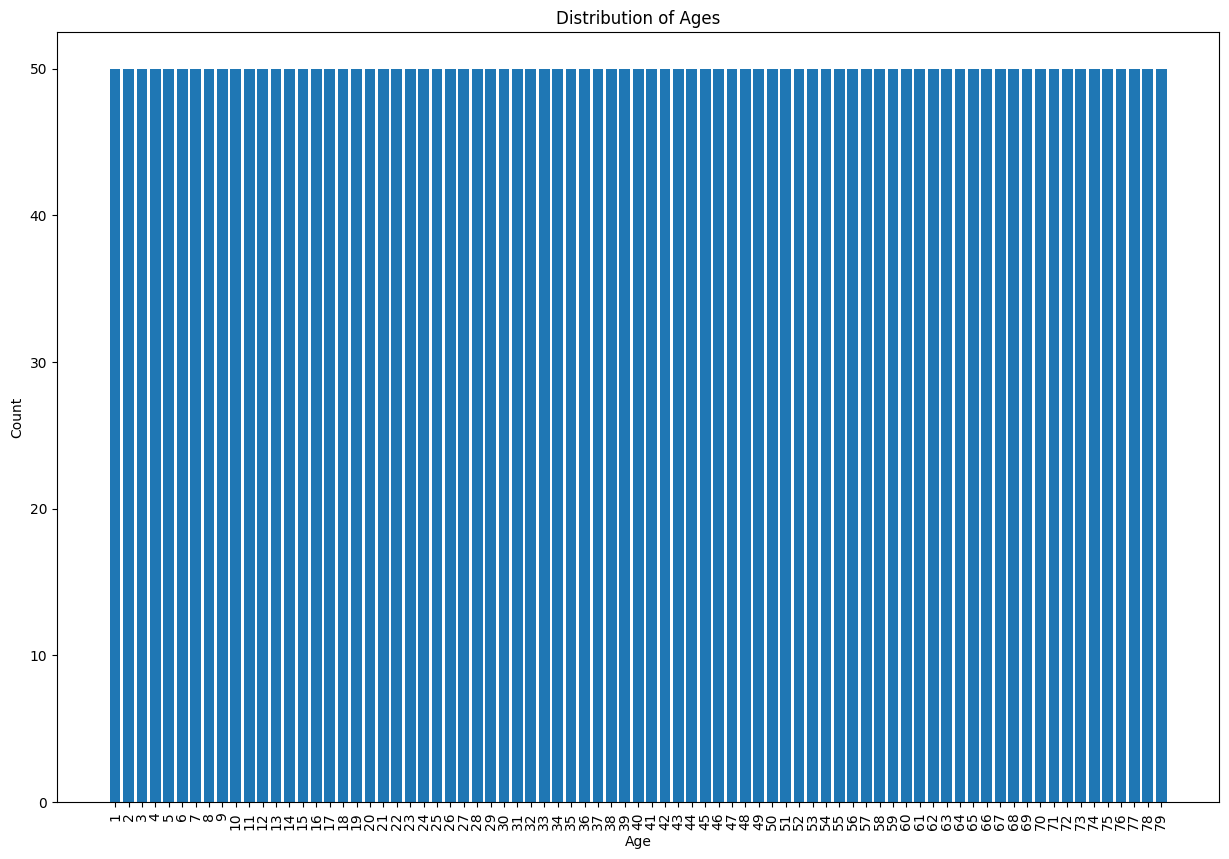

Maximum age: 79


In [17]:
distribution_list = list(set(ages))
distribution_list_int = [int(s) for s in distribution_list]
distribution_list_sorted = sorted(distribution_list_int)


ages_sorted = [str(i).zfill(1) for i in distribution_list_sorted]

x_ages = list(set(ages_sorted))
x_ages = sorted(x_ages)
y_ages = [ages.count(i) for i in x_ages]

plt.figure(figsize=(15, 10)) # set the size of the figure
plt.bar(ages_sorted, y_ages)

plt.xticks(rotation=90) # rotate the x-axis labels by 90 degrees
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')

plt.show()

max_age = max(map(int, x_ages))
print("Maximum age:", max_age)


In [18]:
labels_age = np.zeros((total_ages,1),dtype='float32')
labels_gender = np.zeros((total_genders,1),dtype='float32')
features_age = np.zeros((total_image_age_list,for_np0.shape[0],for_np0.shape[1],3),dtype = 'float32')
#features_gender = np.zeros((total_genders,sample.shape[0],sample.shape[1],3),dtype = 'float32')
features_gender = np.zeros((total_image_gender_list,for_np0.shape[0],for_np0.shape[1],3),dtype = 'float32')

In [19]:
total_image_age_list

3950

In [20]:
print(labels_age.shape)
print(features_age.shape)
print(labels_gender.shape)
print(features_gender.shape)

(3950, 1)
(3950, 224, 224, 3)
(3950, 1)
(3950, 224, 224, 3)


In [21]:
for i in range(total_image_age_list):
    labels_gender[i, 0] = int(genders[i])
    labels_age[i, 0] = int(ages[i])
    features_age[i] = img_age_list[i]
    features_gender[i] = img_gender_list[i]

In [22]:
labels_age[555]

array([27.], dtype=float32)

In [23]:
labels_gender[4]

array([0.], dtype=float32)

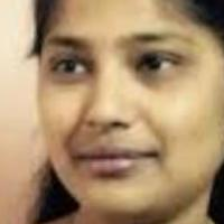

In [24]:
cv2_imshow(features_age[0])

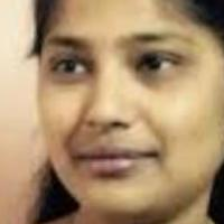

In [25]:
cv2_imshow(features_gender[0])

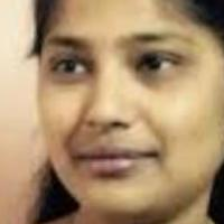

First image in features


In [26]:
# Rescale pixel values to range [0,255]
features_first_img = np.clip(features_age[0], 0, 255)

cv2_imshow(features_first_img)
print("First image in features")


In [27]:
normalized_age = features_age / 255 #normalization
normalized_gender = features_gender /255
features_age[0]

array([[[201., 229., 246.],
        [201., 229., 246.],
        [201., 229., 246.],
        ...,
        [ 17.,  10.,  15.],
        [ 16.,  10.,  15.],
        [ 16.,  10.,  15.]],

       [[201., 229., 246.],
        [201., 229., 246.],
        [201., 229., 246.],
        ...,
        [ 17.,  10.,  15.],
        [ 16.,  10.,  15.],
        [ 15.,   9.,  14.]],

       [[201., 229., 246.],
        [201., 229., 246.],
        [201., 229., 246.],
        ...,
        [ 16.,  10.,  13.],
        [ 15.,  10.,  13.],
        [ 15.,  10.,  13.]],

       ...,

       [[107., 145., 187.],
        [107., 145., 187.],
        [109., 146., 186.],
        ...,
        [  4.,   2.,   7.],
        [  6.,   2.,   7.],
        [  9.,   3.,   8.]],

       [[106., 144., 186.],
        [107., 145., 187.],
        [109., 146., 186.],
        ...,
        [  3.,   1.,   6.],
        [  5.,   1.,   6.],
        [  8.,   2.,   7.]],

       [[106., 144., 186.],
        [107., 145., 187.],
        [109., 1

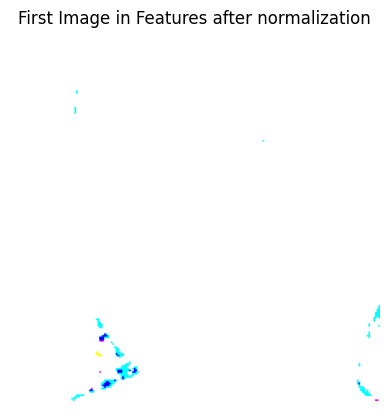

In [28]:
features_first_img_after_normalization = np.clip(features_age[0], 0, 255)
plt.imshow(features_first_img_after_normalization[:, :], vmin=0, vmax=1)
#plt.imshow(features_first_img_after_normalization[:, :, ::-1], vmin=0, vmax=1)
plt.axis('off')

plt.title("First Image in Features after normalization")

plt.show()


In [29]:
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(normalized_age, labels_age, test_size=0.2,shuffle  = True)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(normalized_gender, labels_gender, test_size=0.2,shuffle  = True)

In [30]:
print('number of x_train for gender: ', len(x_train_gender))
print('number of x_test for gender: ', len(x_test_gender))
print('number of y_train for gender: ', len(y_train_gender))
print('number of y_test for gender:', len(y_test_gender))
print("--------------------------------------")
print('number of x_train for age: ', len(x_train_age))
print('number of x_test for age: ', len(x_test_age))
print('number of y_train for age: ', len(y_train_age))
print('number of y_test for age:', len(y_test_age))
print("--------------------------------------")
print('x_train type for gender:', type(x_train_gender))
print('x_test type for gender:', type(x_test_gender))
print('y_train type for gender:', type(y_train_gender))
print('y_test type for gender:', type(y_test_gender))
print("--------------------------------------")
print('x_train type for age:', type(x_train_age))
print('x_test type for age:', type(x_test_age))
print('y_train type for age:', type(y_train_age))
print('y_test type for age:', type(y_test_age))
print("--------------------------------------")
print(x_train_gender.shape)
print(x_test_gender.shape)
print(y_train_age.shape)
print(y_train_gender.shape)
print(y_test_age.shape)
print(y_test_gender.shape)

number of x_train for gender:  3160
number of x_test for gender:  790
number of y_train for gender:  3160
number of y_test for gender: 790
--------------------------------------
number of x_train for age:  3160
number of x_test for age:  790
number of y_train for age:  3160
number of y_test for age: 790
--------------------------------------
x_train type for gender: <class 'numpy.ndarray'>
x_test type for gender: <class 'numpy.ndarray'>
y_train type for gender: <class 'numpy.ndarray'>
y_test type for gender: <class 'numpy.ndarray'>
--------------------------------------
x_train type for age: <class 'numpy.ndarray'>
x_test type for age: <class 'numpy.ndarray'>
y_train type for age: <class 'numpy.ndarray'>
y_test type for age: <class 'numpy.ndarray'>
--------------------------------------
(3160, 224, 224, 3)
(790, 224, 224, 3)
(3160, 1)
(3160, 1)
(790, 1)
(790, 1)


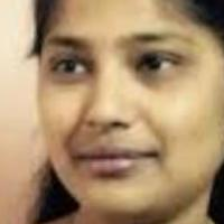

Filename: 27_1_3_20170119194359132.jpg.chip.jpg
Actual age: 27
Gender: 1


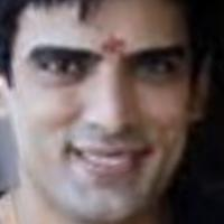

Filename: 25_0_3_20170117151048707.jpg.chip.jpg
Actual age: 25
Gender: 0


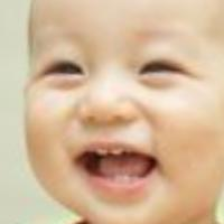

Filename: 1_0_2_20161219161919870.jpg.chip.jpg
Actual age: 1
Gender: 0


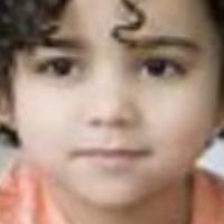

Filename: 2_1_4_20170103205810354.jpg.chip.jpg
Actual age: 2
Gender: 1


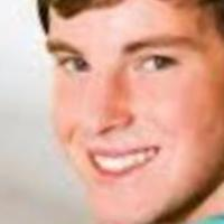

Filename: 20_0_0_20170105183430767.jpg.chip.jpg
Actual age: 20
Gender: 0


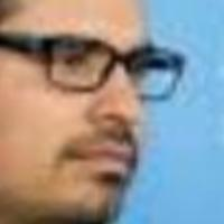

Filename: 26_0_4_20170117200225399.jpg.chip.jpg
Actual age: 26
Gender: 0


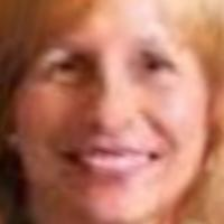

Filename: 40_1_0_20170117091304525.jpg.chip.jpg
Actual age: 40
Gender: 1


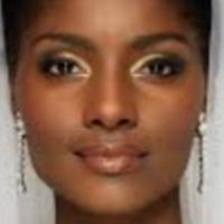

Filename: 20_1_1_20170113005500606.jpg.chip.jpg
Actual age: 20
Gender: 1


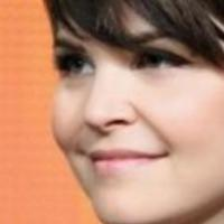

Filename: 26_1_0_20170117175317465.jpg.chip.jpg
Actual age: 26
Gender: 1


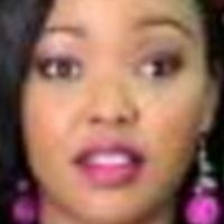

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Actual age: 26
Gender: 1


In [31]:
for i in range(10):
  filenumber = img_gender_list[i]
  cv2_imshow(filenumber)
  name_of_files = filenames[i]
  print("Filename:", name_of_files)
  print("Actual age:", ages[i])
  print("Gender:", genders[i])

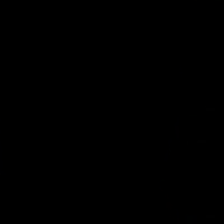

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [1.]


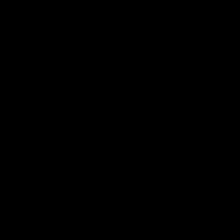

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [0.]


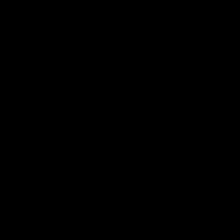

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [0.]


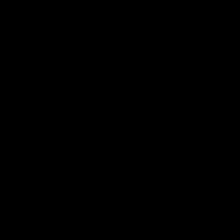

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [0.]


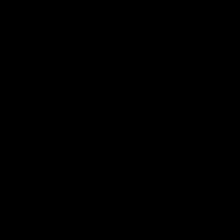

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [1.]


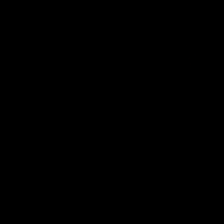

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [1.]


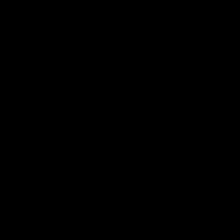

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [0.]


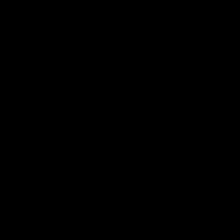

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [0.]


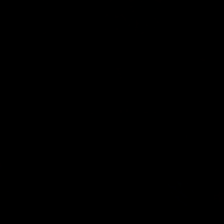

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [0.]


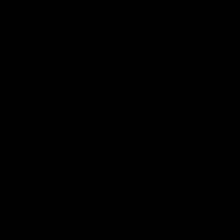

Filename: 26_1_1_20170116153234172.jpg.chip.jpg
Gender: [0.]


In [32]:
for i in range(10):
  filenumber = x_train_gender[i]
  cv2_imshow(filenumber)
  print("Filename:", name_of_files)
  print("Gender:", y_train_gender[i])

In [33]:
for i in range (50):
  print(y_train_gender[i])

[1.]
[0.]
[0.]
[0.]
[1.]
[1.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]


In [34]:
#age
input_shape = (224, 224, 3)
inputs_age = Input(shape=input_shape)

x_age = Conv2D(32, (3,3), activation='relu', kernel_initializer='random_uniform')(inputs_age)
x_age = MaxPooling2D((2, 2))(x_age)
x_age = Dropout(0.5)(x_age)
x_age = Conv2D(64, (3,3), activation='relu', kernel_initializer='random_uniform')(x_age)
x_age = MaxPooling2D((2, 2))(x_age)
x_age = Dropout(0.5)(x_age)
x_age = Conv2D(128, (3,3), activation='relu', kernel_initializer='random_uniform')(x_age)
x_age = MaxPooling2D((2, 2))(x_age)
x_age = Dropout(0.5)(x_age)

x_age = Flatten()(x_age)
x_age = Dense(64, activation='relu', kernel_initializer='random_uniform')(x_age)
outputs_age = Dense(1, activation='linear', kernel_initializer='random_uniform')(x_age)

neural_network_age = Model(inputs=inputs_age, outputs=outputs_age)
neural_network_age.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

#gender
inputs_gender = Input(shape=(224, 224, 3))
x_gender = Conv2D(32, (3, 3), activation='relu', kernel_initializer='random_uniform')(inputs_gender)
x_gender = MaxPooling2D((2, 2))(x_gender)
x_gender = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_uniform')(x_gender)
x_gender = MaxPooling2D((2, 2))(x_gender)
x_gender = Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_uniform')(x_gender)
x_gender = MaxPooling2D((2, 2))(x_gender)
x_gender = Flatten()(x_gender)

#Add dense layer
x_gender = Dense(128, activation='relu', kernel_initializer='random_uniform')(x_gender)
x_gender = Dropout(0.5)(x_gender)
x_gender = Dense(64, activation='relu', kernel_initializer='random_uniform')(x_gender)
x_gender = Dropout(0.5)(x_gender)
x_gender = BatchNormalization()(x_gender)
outputs_gender = Dense(1, activation='sigmoid', kernel_initializer='random_uniform')(x_gender)

neural_network_gender = Model(inputs=inputs_gender, outputs=outputs_gender)
neural_network_gender.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [35]:
# Define some callbacks to avoid overfitting
callbacks = [ ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=2) ]

# Train the model
history_age = neural_network_age.fit(x_train_age, y_train_age,
                    batch_size = 64,
                    epochs=45,
                    validation_data=(x_test_age, y_test_age),
                    callbacks=callbacks)


Epoch 1/45
50/50 [==============================] - 24s 205ms/step - loss: 756.7575 - mae: 22.4835 - val_loss: 951.3918 - val_mae: 25.1950 - lr: 0.0010
Epoch 2/45
50/50 [==============================] - 8s 167ms/step - loss: 581.3060 - mae: 20.3682 - val_loss: 800.3356 - val_mae: 23.1961 - lr: 0.0010
Epoch 3/45
50/50 [==============================] - 8s 167ms/step - loss: 534.9412 - mae: 19.9150 - val_loss: 677.6221 - val_mae: 21.6235 - lr: 0.0010
Epoch 4/45
50/50 [==============================] - 8s 167ms/step - loss: 522.7276 - mae: 19.7409 - val_loss: 615.2814 - val_mae: 20.8124 - lr: 0.0010
Epoch 5/45
50/50 [==============================] - 8s 166ms/step - loss: 494.6354 - mae: 19.1766 - val_loss: 683.6210 - val_mae: 21.5856 - lr: 0.0010
Epoch 6/45
50/50 [==============================] - 8s 166ms/step - loss: 484.8283 - mae: 18.8576 - val_loss: 704.7664 - val_mae: 21.8784 - lr: 0.0010
Epoch 7/45
50/50 [==============================] - 8s 165ms/step - loss: 474.7373 - mae: 18.

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=2) ]

history_gender = neural_network_gender.fit(x_train_gender, y_train_gender,
                    batch_size=64,
                    epochs=45,
                    validation_data=(x_test_gender, y_test_gender),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/45
50/50 [==============================] - 8s 116ms/step - loss: 0.6896 - accuracy: 0.5272 - val_loss: 0.6788 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 2/45
50/50 [==============================] - 5s 95ms/step - loss: 0.6440 - accuracy: 0.6332 - val_loss: 0.6326 - val_accuracy: 0.6582 - lr: 0.0010
Epoch 3/45
50/50 [==============================] - 5s 95ms/step - loss: 0.6141 - accuracy: 0.6820 - val_loss: 0.5932 - val_accuracy: 0.6937 - lr: 0.0010
Epoch 4/45
50/50 [==============================] - 5s 99ms/step - loss: 0.5936 - accuracy: 0.6911 - val_loss: 0.5759 - val_accuracy: 0.7089 - lr: 0.0010
Epoch 5/45
50/50 [==============================] - 5s 96ms/step - loss: 0.5248 - accuracy: 0.7506 - val_loss: 0.5486 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 6/45
50/50 [==============================] - 5s 96ms/step - loss: 0.4739 - accuracy: 0.7848 - val_loss: 0.5297 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 7/45
50/50 [==============================] - 5s 95ms/step - loss: 0.

In [ ]:
gender_pred = neural_network_gender.predict(x_test_gender)
age_pred = neural_network_age.predict(x_test_age)


In [ ]:
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

for i in range(50):
  filenumber = img_gender_list[i]
  cv2_imshow(filenumber)
  name_of_files = filenames[i]
  val = neural_network_gender.predict( np.array([ filenumber ]) )
  print("Filename:", name_of_files)
  print("Real age    | Predict age")
  print(ages[i], "         |" , int(age_pred[i]))
  print("Real gender | Predict gender")
  print(get_gender(genders[i]), "     |" , get_gender(val[0][0]))

In [ ]:
neural_network_age.save('neural_network_age.h5')
neural_network_gender.save('neural_network_gender.h5')


In [ ]:
plt.plot(history_age.history['mae'])
plt.plot(history_age.history['val_mae'])
plt.title('CNN model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(["MAE","Validation MAE"])
plt.show()

In [ ]:
plt.plot(history_age.history['loss'])
plt.plot(history_age.history['val_loss'])
plt.title('CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_age, age_pred))
print("RMSE of age model: ", rmse)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_gender = neural_network_gender.predict(x_test_gender)
y_pred_gender = np.round(gender_pred).flatten()

cm = confusion_matrix(y_test_gender, y_pred_gender)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
def error_count(error):
  error1 = 0
  error2 = 0
  error3 = 0
  error4 = 0
  if error < 5:
    error1 = error1+1
  elif error <= 10:
    error2 = error2+1
  elif error <= 15:
    error3 = error3+1
  elif error > 15:
    error4 = error4+1
  return error1,error2,error3,error4

In [ ]:
predicted_age_list = []
y_test_list = []
error1_total = 0
error2_total = 0
error3_total = 0
error4_total = 0

for i in range(len(x_test_age)):
    #image = x_test_gender[i]
    #name_of_files = x_test_age[i]
    predicted_age = neural_network_age.predict(np.expand_dims(x_test_age[i], axis=0))
    predicted_age = int(predicted_age)
    predicted_age_list.append(predicted_age)
    percent_dif =  (abs(predicted_age-int(y_test_age[i]))/ int(max_age)) * 100
    error_count(percent_dif)
    error1, error2, error3, error4 = error_count(percent_dif)
    error1_total += error1
    error2_total += error2
    error3_total += error3
    error4_total += error4

print("Number of error less than 5%:", error1_total)
print("Number of error less than 10%:", error2_total)
print("Number of error equal or less than 15%:", error3_total)
print("Number of error more than 15%:", error4_total)

In [ ]:
percentage_error1 = (error1_total/len(x_test_age))*100
percentage_error2 = (error2_total/len(x_test_age))*100
percentage_error3 = (error3_total/len(x_test_age))*100
percentage_error4 = (error4_total/len(x_test_age))*100
print("Percentage of file that have 0-5 % error : ", round(percentage_error1,2), " %")
print("Percentage of file that have 6-10 % error: ", round(percentage_error2,2), " %")
print("Percentage of file that have 11-15 % error:", round(percentage_error3,2), " %")
print("Percentage of file that have more than 15% error : ", round(percentage_error4,2), " %")

In [ ]:

values = [error1_total, error2_total, error3_total, error4_total]
labels = ['<5%', '<10%', '<=15%', '>15%']

# Plot the bar graph
plt.bar(labels, values)

# Add labels to the graph
plt.title('%error Random initialization')
plt.xlabel('Percentage error')
plt.ylabel('Count')

# Display the graph
plt.show()


In [ ]:
neural_network_age.summary()

In [ ]:
neural_network_gender.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(neural_network_age, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
plot_model(neural_network_gender, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
age_estimation_loaded = keras.models.load_model('neural_network_age.h5')

In [ ]:
me_grayscale = cv2.imread('/content/339789340_768770211326216_5200307492602980872_n.jpg', 0)
me_grayscale = me_grayscale/255
me_resized = cv2.resize(me_grayscale, (224, 224))
me_reshaped = np.reshape(me_resized, (224, 224, 1))
me_reshaped_expanded = np.expand_dims(me_reshaped, axis=0) # for convert (224,224,1) to (None,224,224,1)

In [ ]:
me_grayscale = cv2.imread('/content/38_1_0_20170104201451243.jpg.chip.jpg', 1)
me_grayscale = me_grayscale/255
me_resized = cv2.resize(me_grayscale, (224, 224))
me_reshaped = np.reshape(me_resized, (224, 224, 3))
test_reshaped_expanded = np.expand_dims(me_reshaped, axis=0) # for convert (224,224,1) to (None,224,224,1)

In [ ]:
cv2_imshow(me_reshaped)

In [ ]:
res = age_estimation_loaded.predict(test_reshaped_expanded)
res

In [ ]:
print(neural_network_gender.predict(test_reshaped_expanded))

In [ ]:
print(age_estimation_loaded.input_shape)
print(test_reshaped_expanded.shape)

In [ ]:
age_estimation_loaded.summary()